### Setup Environment:

In [13]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [14]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'DR_ICDR'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [15]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [16]:
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else 'Diabetic Retinopathy')

Train data shape: (11386, 35)
Test data shape: (4880, 35)


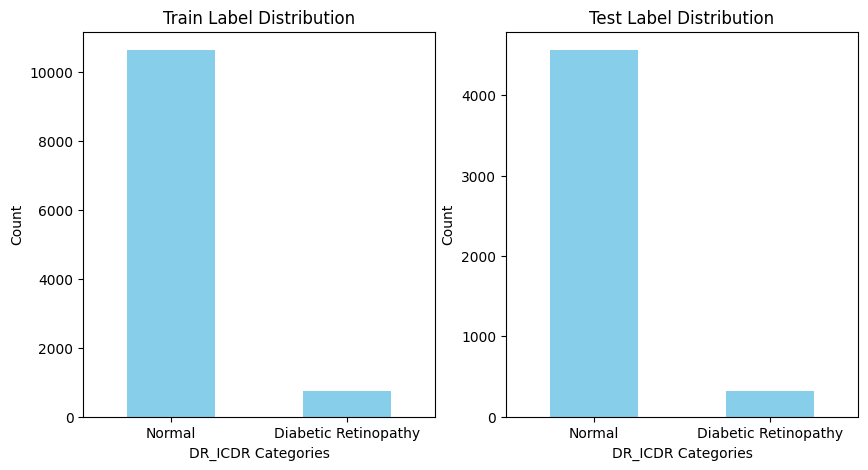

Getting validation set...
Train data shape: (10247, 35)
Test data shape: (1139, 35)


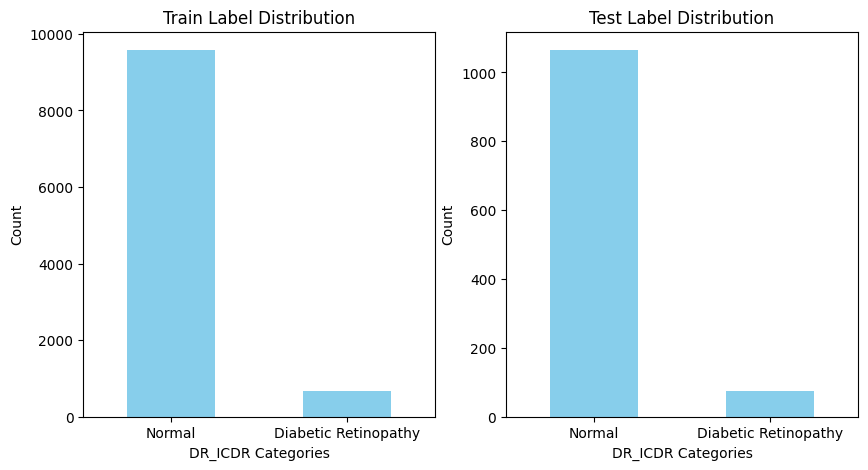

In [17]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_train, df_val = split_data(df_train, LABEL, 0.10)

### Dataloaders

In [18]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [19]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [20]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

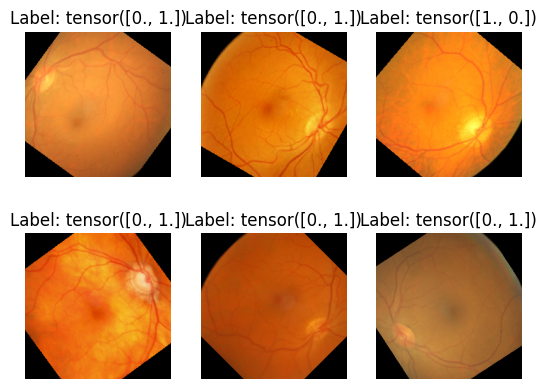

In [21]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [22]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [23]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [24]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}')

100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 1, Train Loss: 0.5783396289333724, Val Loss: 0.5768749057832692, F1 Score: 0.48750454080116246


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 2, Train Loss: 0.5222691717715977, Val Loss: 0.43174572656345034, F1 Score: 0.6981022052586938


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 3, Train Loss: 0.4880429970364954, Val Loss: 0.44007118775819737, F1 Score: 0.7174556686511746


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 4, Train Loss: 0.47492104635084287, Val Loss: 0.6406143312859867, F1 Score: 0.3703414982103507


100%|██████████| 72/72 [00:20<00:00,  3.48it/s]


Epoch 5, Train Loss: 0.4682422373647251, Val Loss: 0.3810278952328695, F1 Score: 0.7684828029572486


100%|██████████| 72/72 [00:21<00:00,  3.42it/s]


Epoch 6, Train Loss: 0.4357139704321829, Val Loss: 0.33146861562919283, F1 Score: 0.7485034347399412


100%|██████████| 72/72 [00:20<00:00,  3.56it/s]


Epoch 7, Train Loss: 0.4180194641784554, Val Loss: 0.32233467253132, F1 Score: 0.8049436580013016


100%|██████████| 72/72 [00:20<00:00,  3.44it/s]


Epoch 8, Train Loss: 0.39357208594819315, Val Loss: 0.3249401047618853, F1 Score: 0.8208518580655986


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 9, Train Loss: 0.37848124704824965, Val Loss: 0.35320767931019265, F1 Score: 0.7513305322128851


100%|██████████| 72/72 [00:20<00:00,  3.45it/s]


Epoch 10, Train Loss: 0.3670411127940541, Val Loss: 0.5219015198656254, F1 Score: 0.6899491198743068


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 11, Train Loss: 0.3652247265213737, Val Loss: 0.2911919471807778, F1 Score: 0.8633725490196078


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 12, Train Loss: 0.3547110637292475, Val Loss: 0.3264506658435696, F1 Score: 0.8211412191493156


100%|██████████| 72/72 [00:20<00:00,  3.53it/s]


Epoch 13, Train Loss: 0.3698189496854538, Val Loss: 0.30413011606368756, F1 Score: 0.8366002843095061


100%|██████████| 72/72 [00:20<00:00,  3.56it/s]


Epoch 14, Train Loss: 0.3174561468866914, Val Loss: 0.2340759743625919, F1 Score: 0.8689779782897192


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 15, Train Loss: 0.29973095565360164, Val Loss: 0.2577632220668925, F1 Score: 0.8366002843095061


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 16, Train Loss: 0.2962767239601908, Val Loss: 0.25088543506960076, F1 Score: 0.8444397098028933


100%|██████████| 72/72 [00:20<00:00,  3.54it/s]


Epoch 17, Train Loss: 0.27626731360618856, Val Loss: 0.24799136579450634, F1 Score: 0.8830143309408154


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 18, Train Loss: 0.29608522618825833, Val Loss: 0.25807978502578205, F1 Score: 0.8571829472175783


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 19, Train Loss: 0.2677785506509768, Val Loss: 0.23154862514800495, F1 Score: 0.8577423625508955


100%|██████████| 72/72 [00:20<00:00,  3.54it/s]


Epoch 20, Train Loss: 0.24447634973085242, Val Loss: 0.23639242785672346, F1 Score: 0.8734433042940326


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 21, Train Loss: 0.2285648139655683, Val Loss: 0.25184441650182837, F1 Score: 0.8546110053696492


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 22, Train Loss: 0.22399792241952535, Val Loss: 0.3751404988320751, F1 Score: 0.8954573695953008


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 23, Train Loss: 0.22761920893596785, Val Loss: 0.22797190762745836, F1 Score: 0.8247166686229247


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 24, Train Loss: 0.2545507409800187, Val Loss: 0.23221989860758185, F1 Score: 0.8918098295147475


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 25, Train Loss: 0.20352192857998674, Val Loss: 0.2591776827401999, F1 Score: 0.8506621214107776


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 26, Train Loss: 0.19129460838488224, Val Loss: 0.28825813526701594, F1 Score: 0.8162532768703368


100%|██████████| 72/72 [00:20<00:00,  3.51it/s]


Epoch 27, Train Loss: 0.16987689293037617, Val Loss: 0.220084522320475, F1 Score: 0.8490691048830584


100%|██████████| 72/72 [00:20<00:00,  3.47it/s]


Epoch 28, Train Loss: 0.1729930508998041, Val Loss: 0.21641149307187232, F1 Score: 0.8897214797689217


100%|██████████| 72/72 [00:20<00:00,  3.55it/s]


Epoch 29, Train Loss: 0.159664864352557, Val Loss: 0.38250174110807067, F1 Score: 0.905498196251788


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 30, Train Loss: 0.14987833372661596, Val Loss: 0.27442561827289563, F1 Score: 0.8226298741746605


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 31, Train Loss: 0.15109085654273233, Val Loss: 0.3128972052363679, F1 Score: 0.8918098295147475


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 32, Train Loss: 0.1350023842615754, Val Loss: 0.2953753259757327, F1 Score: 0.8916063951275219


100%|██████████| 72/72 [00:20<00:00,  3.52it/s]


Epoch 33, Train Loss: 0.13198566616566593, Val Loss: 0.20729286852292717, F1 Score: 0.8816066231320467


100%|██████████| 72/72 [00:20<00:00,  3.49it/s]


Epoch 34, Train Loss: 0.12782133721954272, Val Loss: 0.26196396404540995, F1 Score: 0.8945562269957255


100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Epoch 35, Train Loss: 0.12497481105009359, Val Loss: 0.23151338550572595, F1 Score: 0.8560464884894736


100%|██████████| 72/72 [00:20<00:00,  3.46it/s]


Epoch 36, Train Loss: 0.12434904350188682, Val Loss: 0.2583688884688955, F1 Score: 0.8945562269957255
Early stopping triggered.


### Test

100%|██████████| 305/305 [01:25<00:00,  3.58it/s]


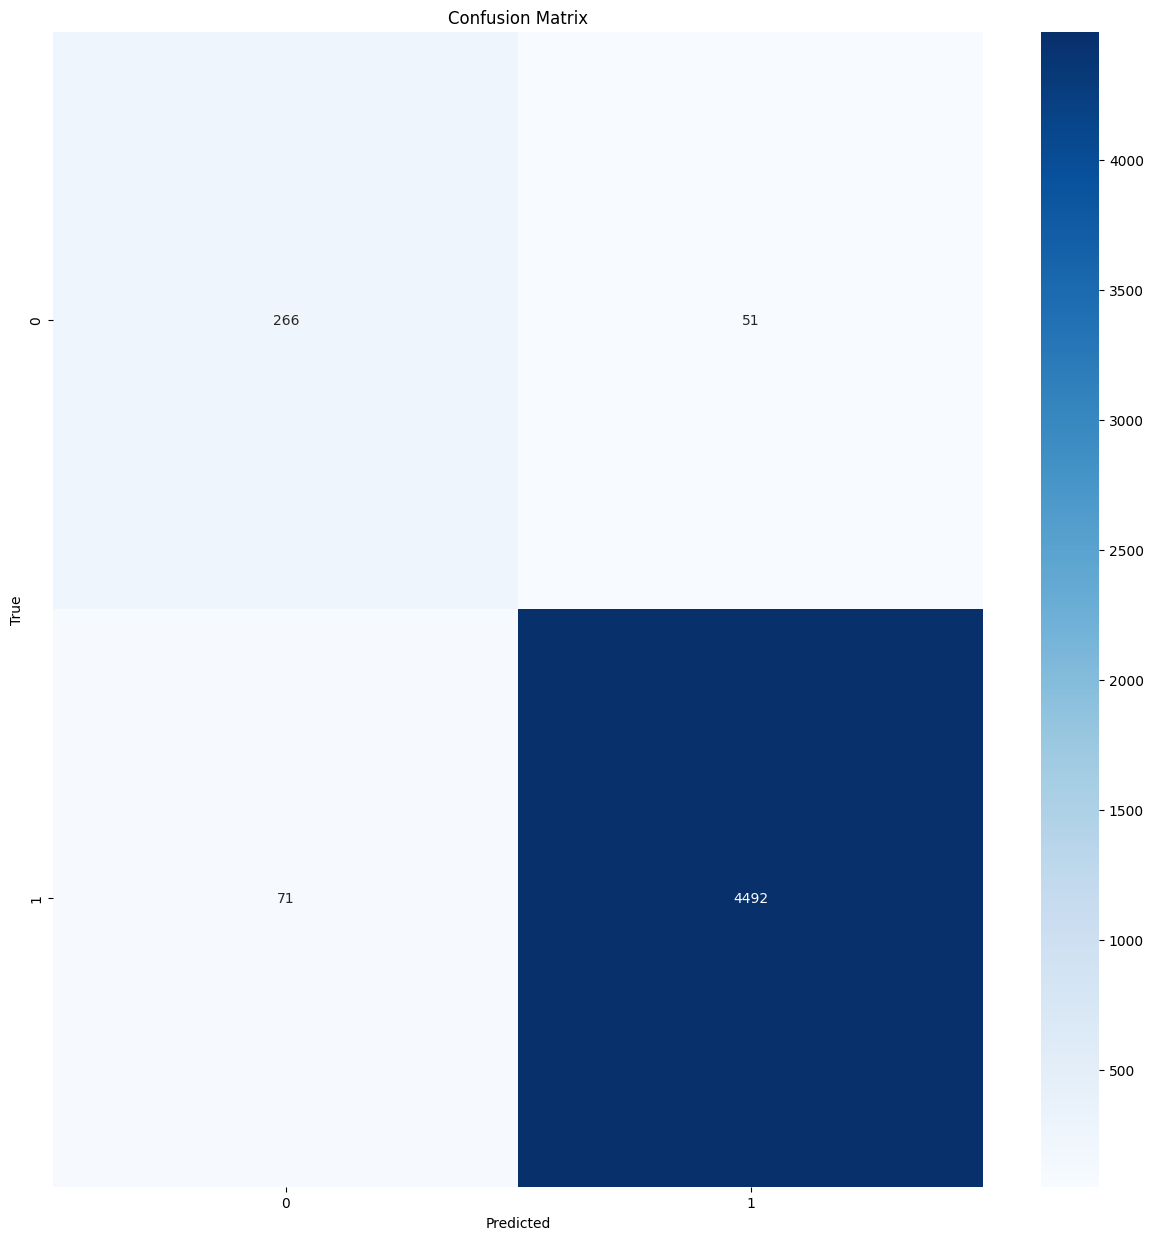

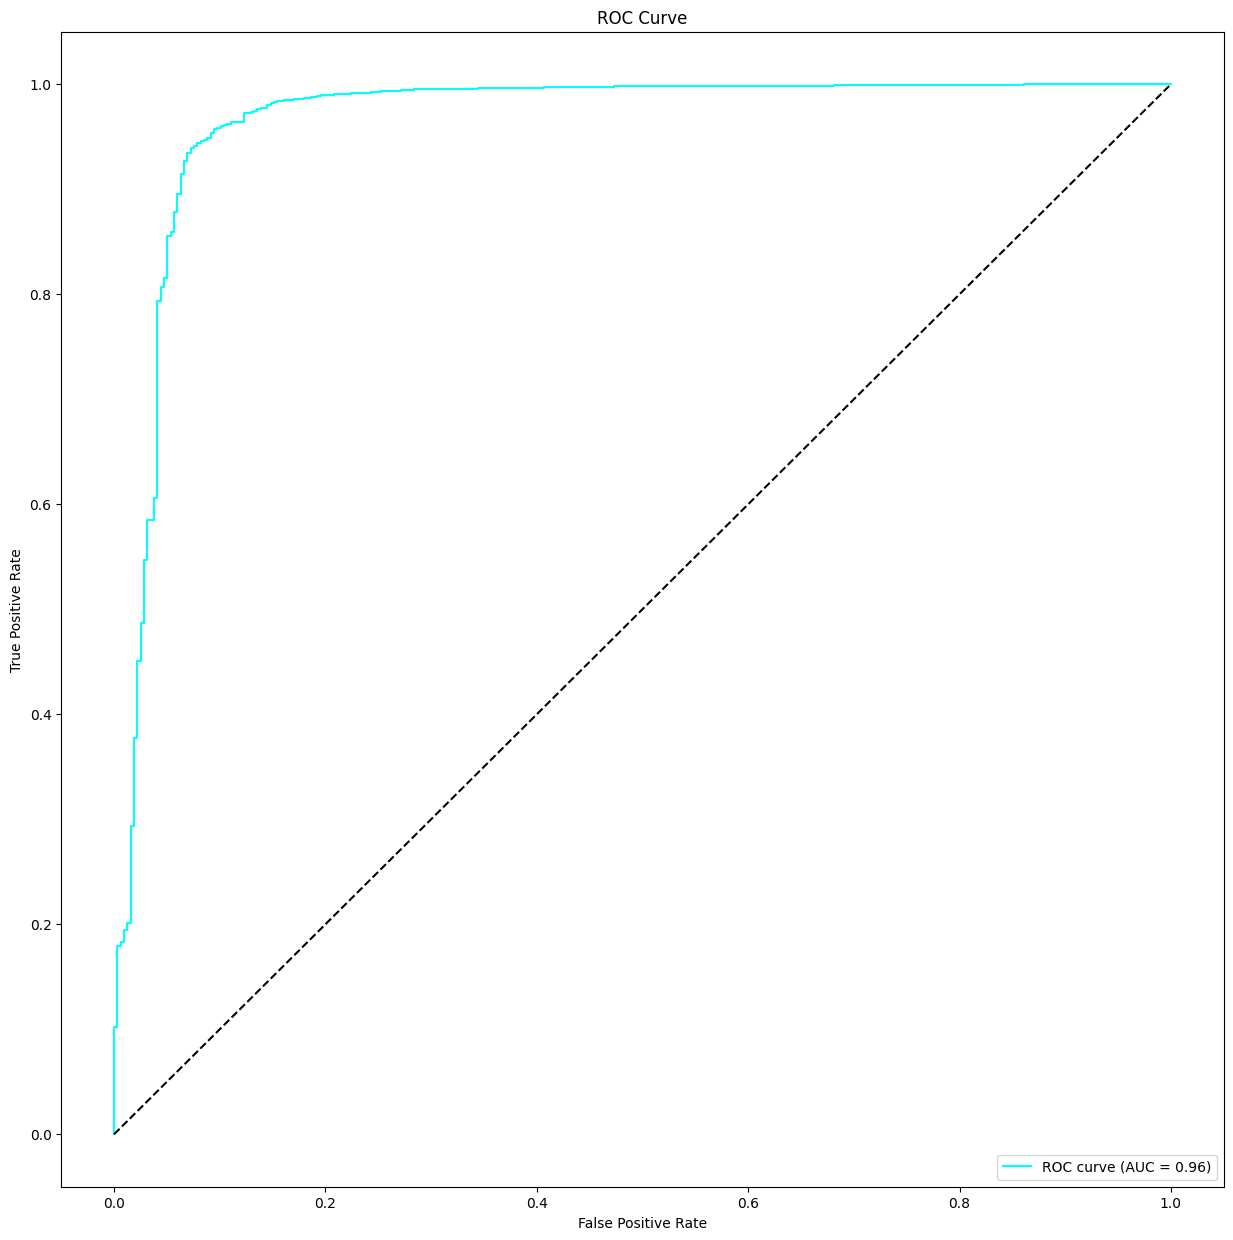

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       317
           1       0.99      0.98      0.99      4563

    accuracy                           0.97      4880
   macro avg       0.89      0.91      0.90      4880
weighted avg       0.98      0.97      0.98      4880

##################################################  Saliency Maps  ##################################################

Class 0:


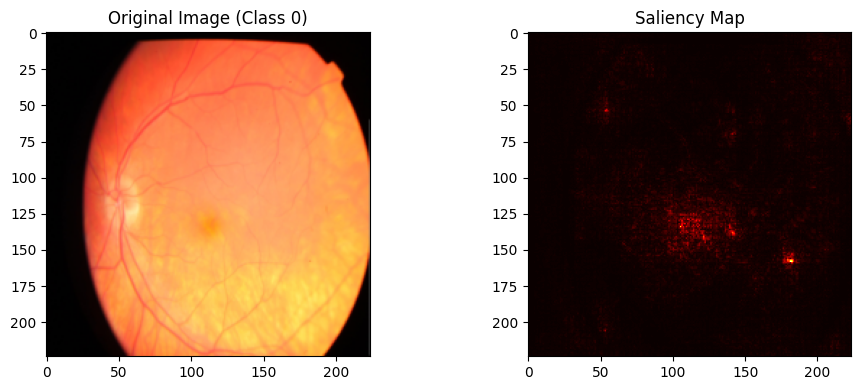

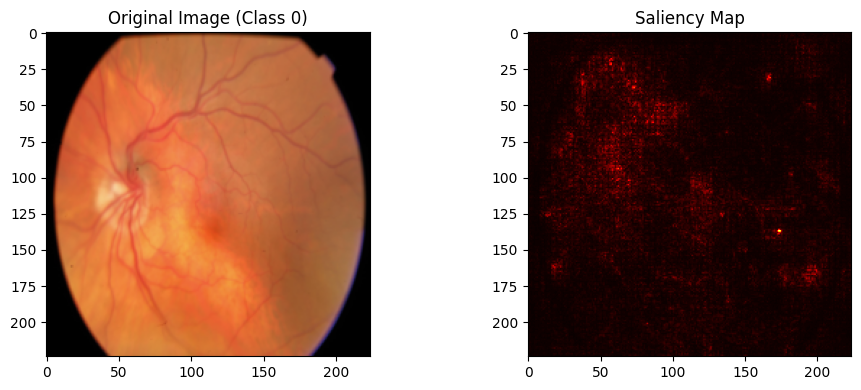

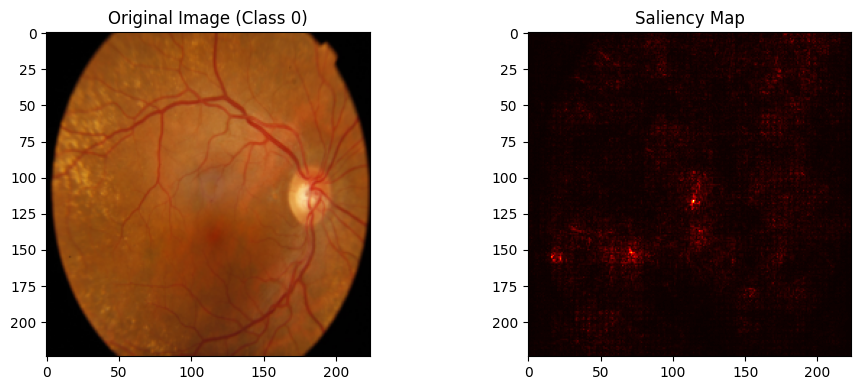

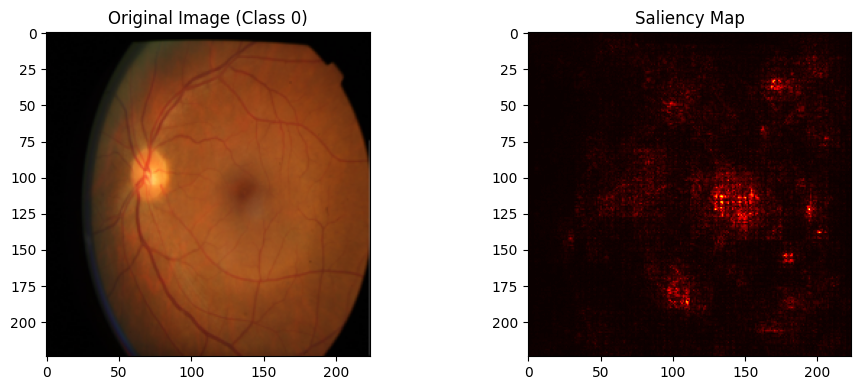

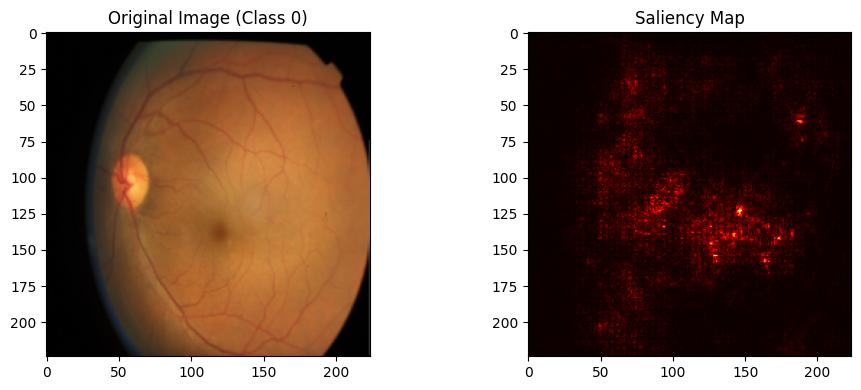

Class 1:


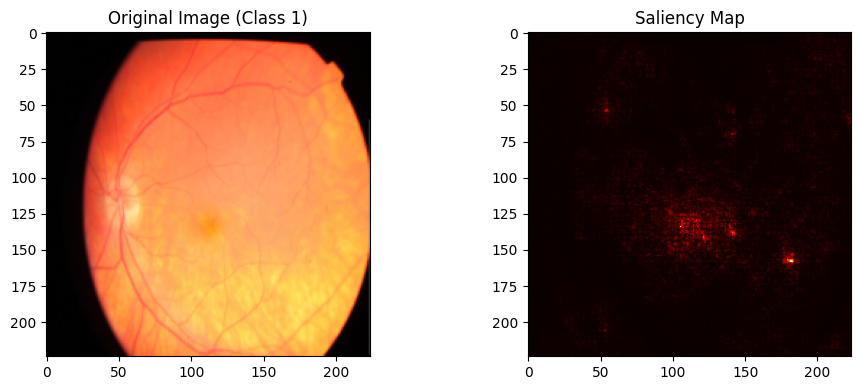

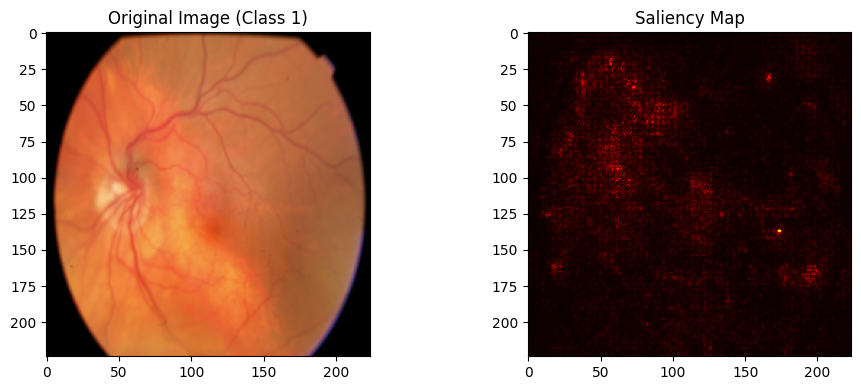

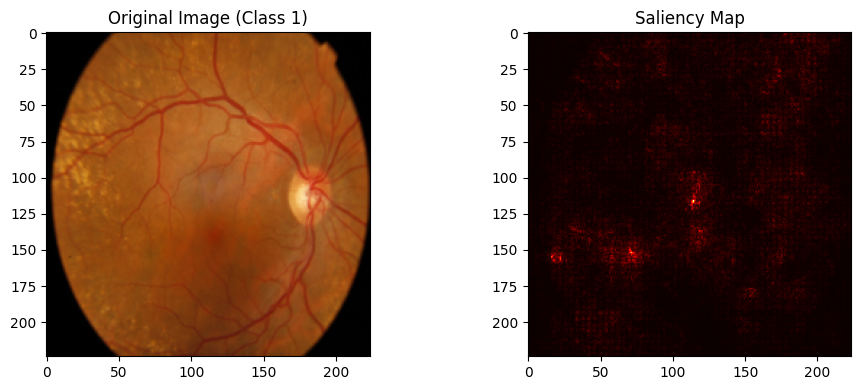

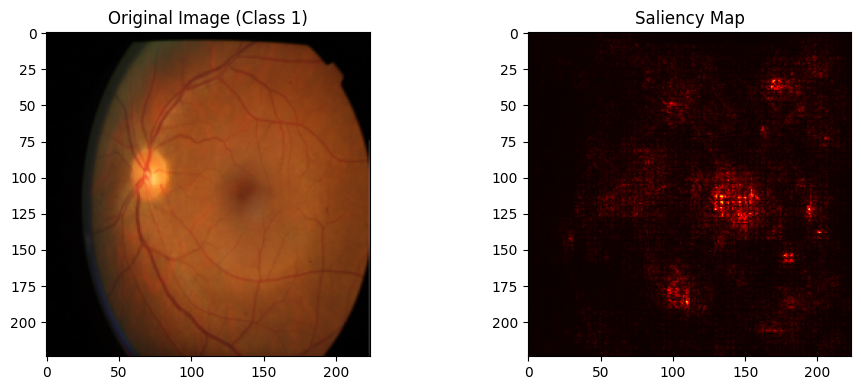

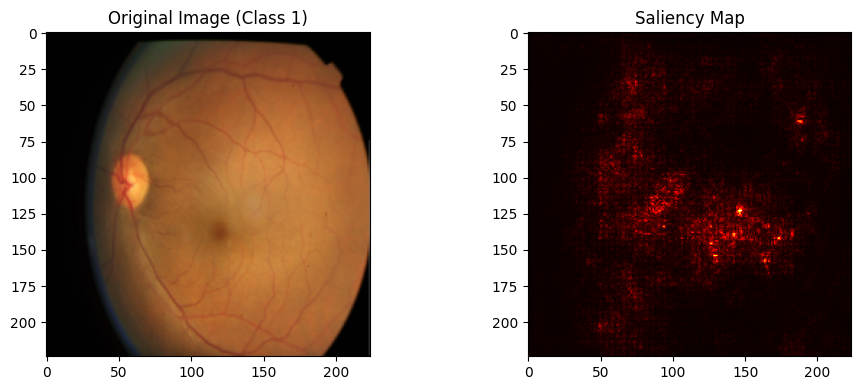

In [25]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [26]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 267/267 [01:14<00:00,  3.57it/s]


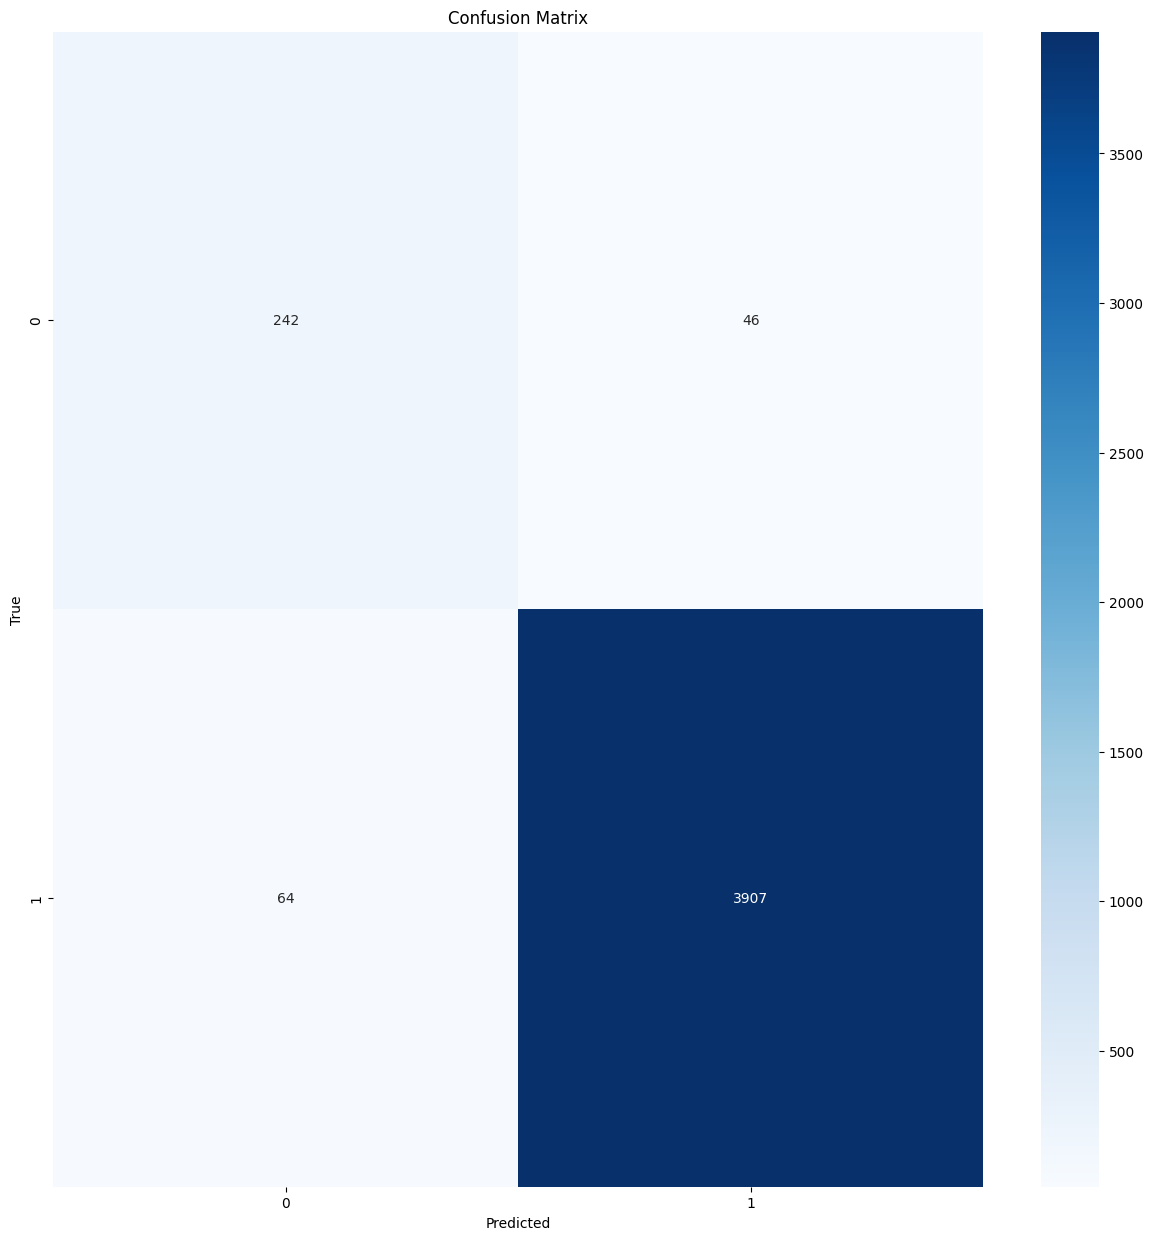

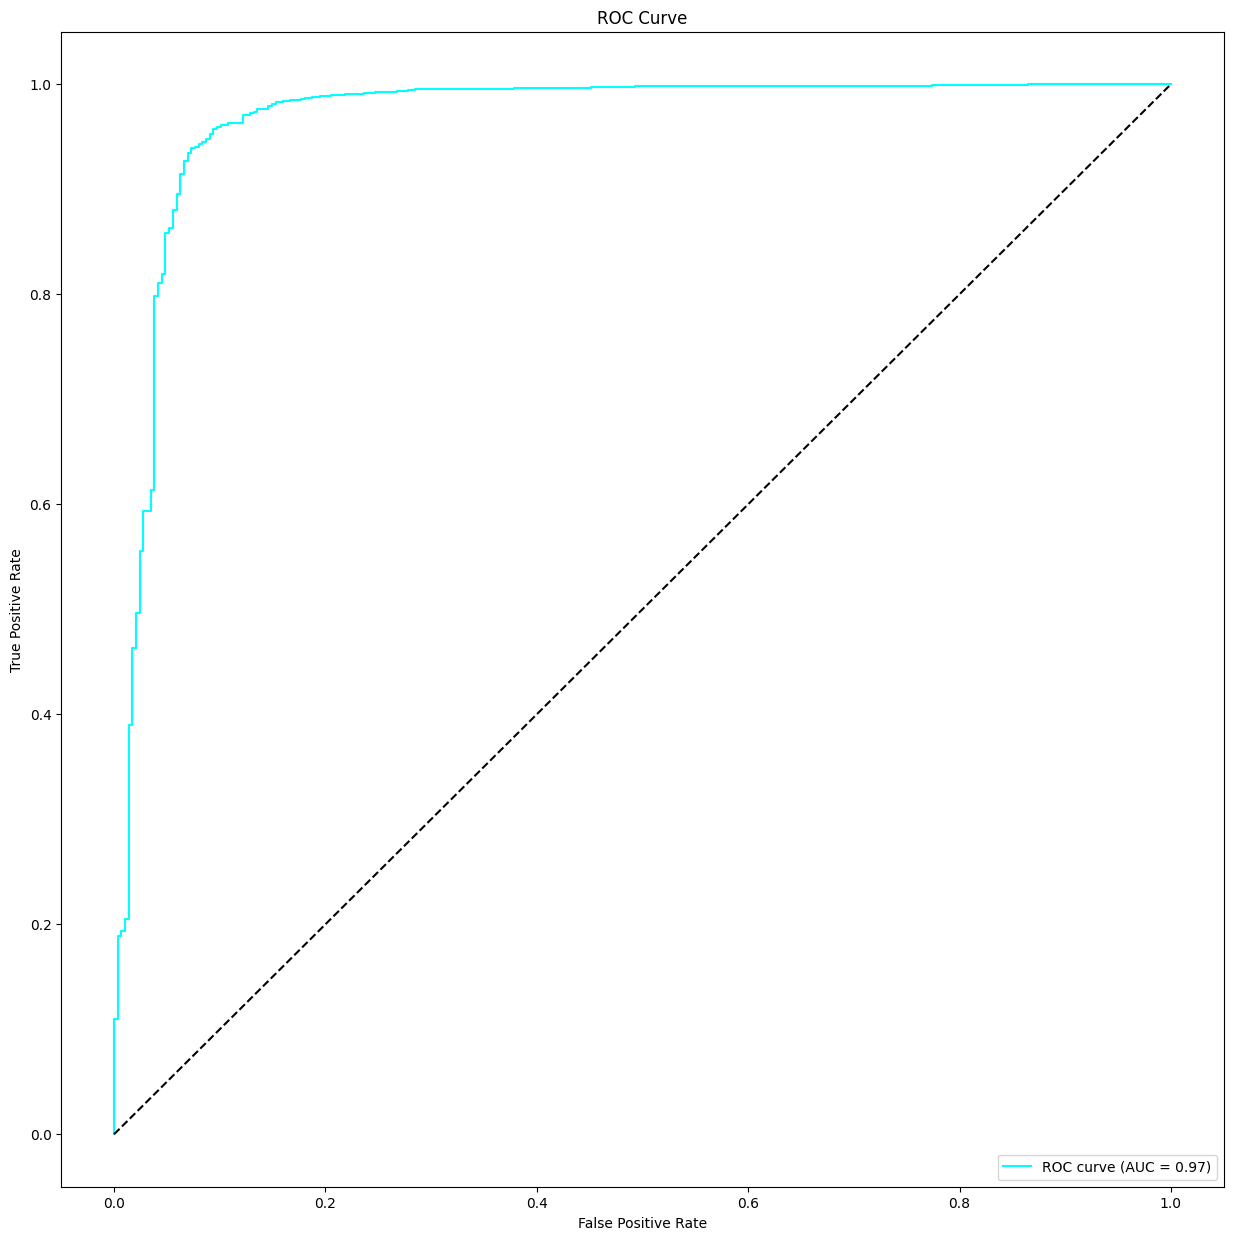

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       288
           1       0.99      0.98      0.99      3971

    accuracy                           0.97      4259
   macro avg       0.89      0.91      0.90      4259
weighted avg       0.98      0.97      0.97      4259

##################################################  Saliency Maps  ##################################################

Class 0:


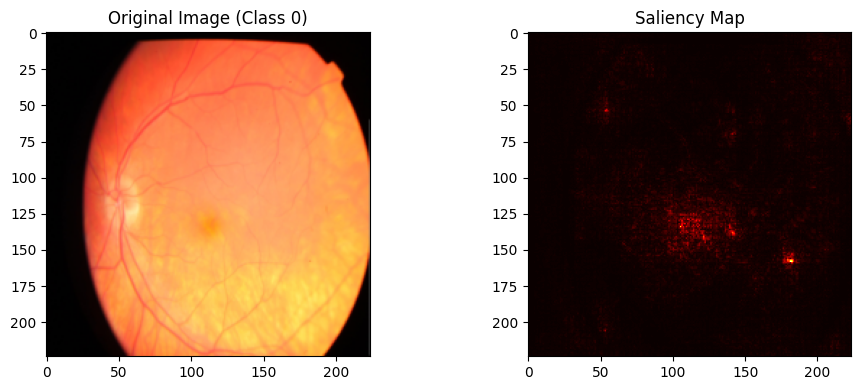

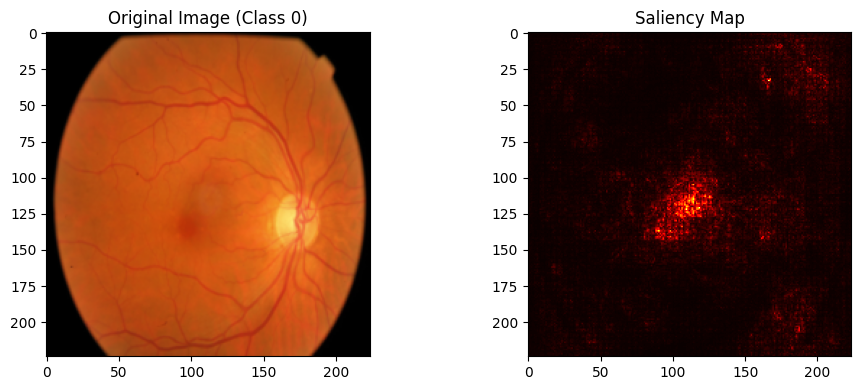

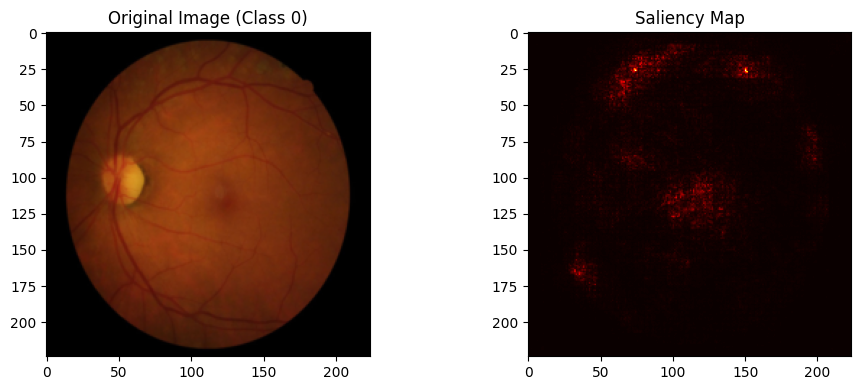

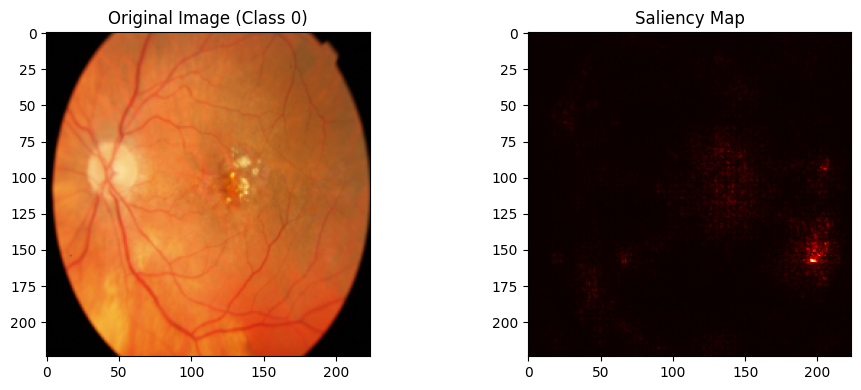

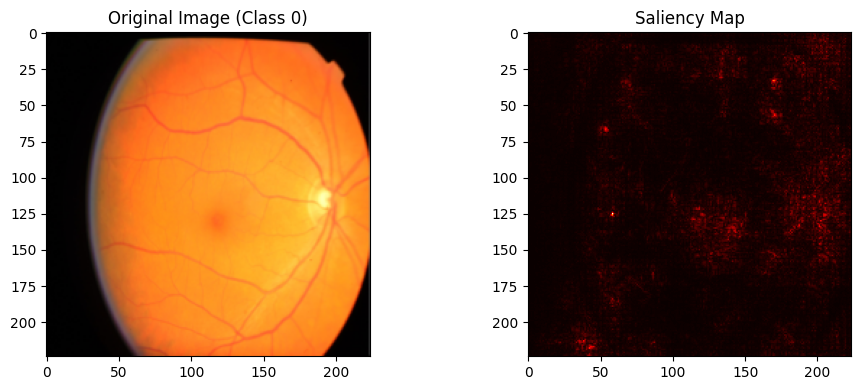

Class 1:


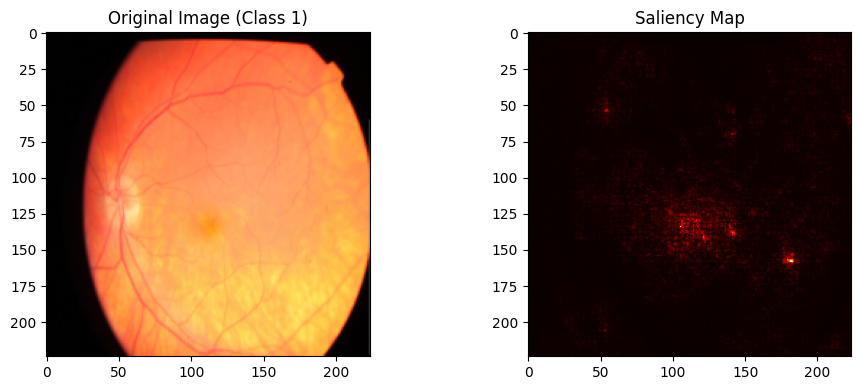

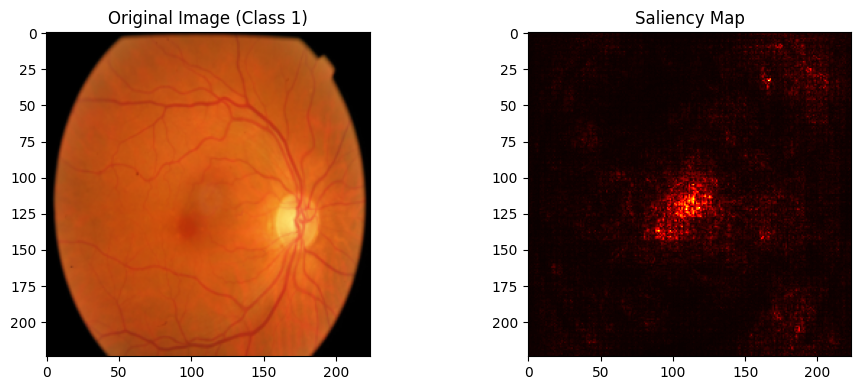

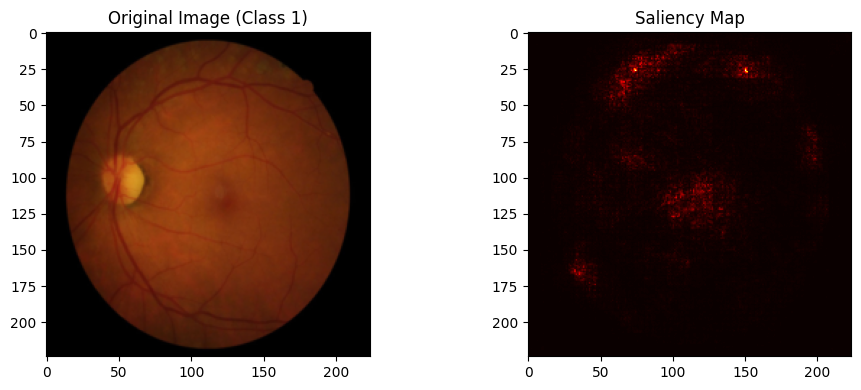

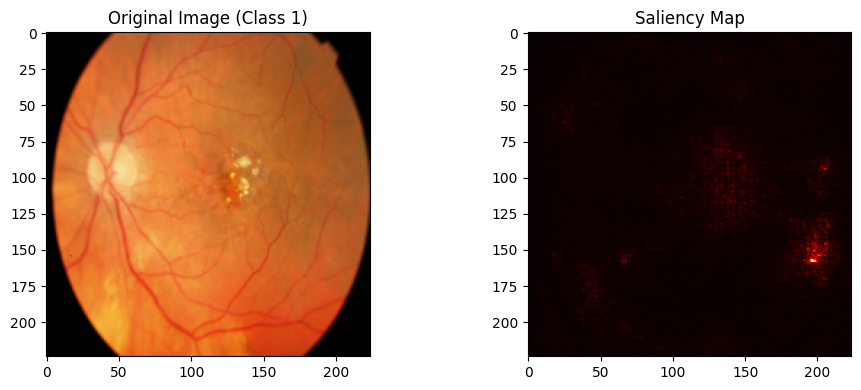

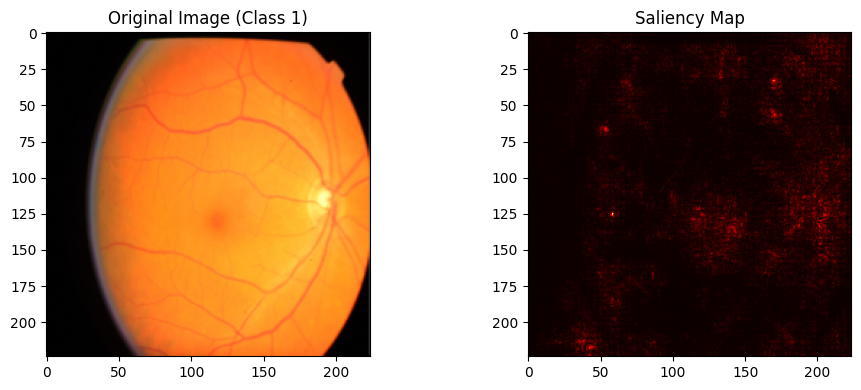

In [27]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 39/39 [00:12<00:00,  3.22it/s]


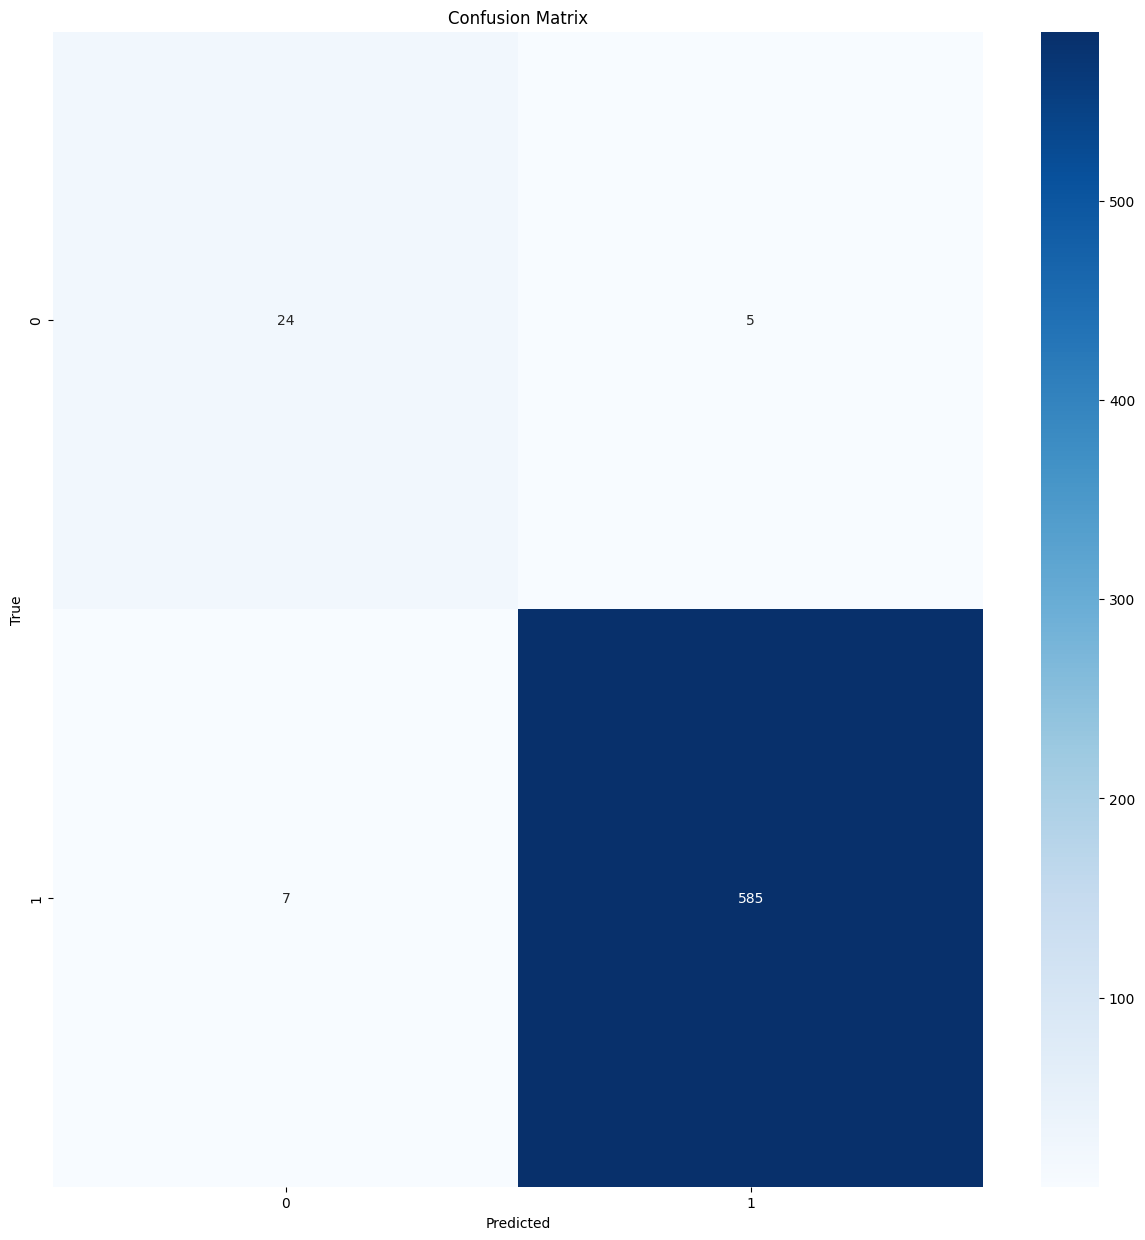

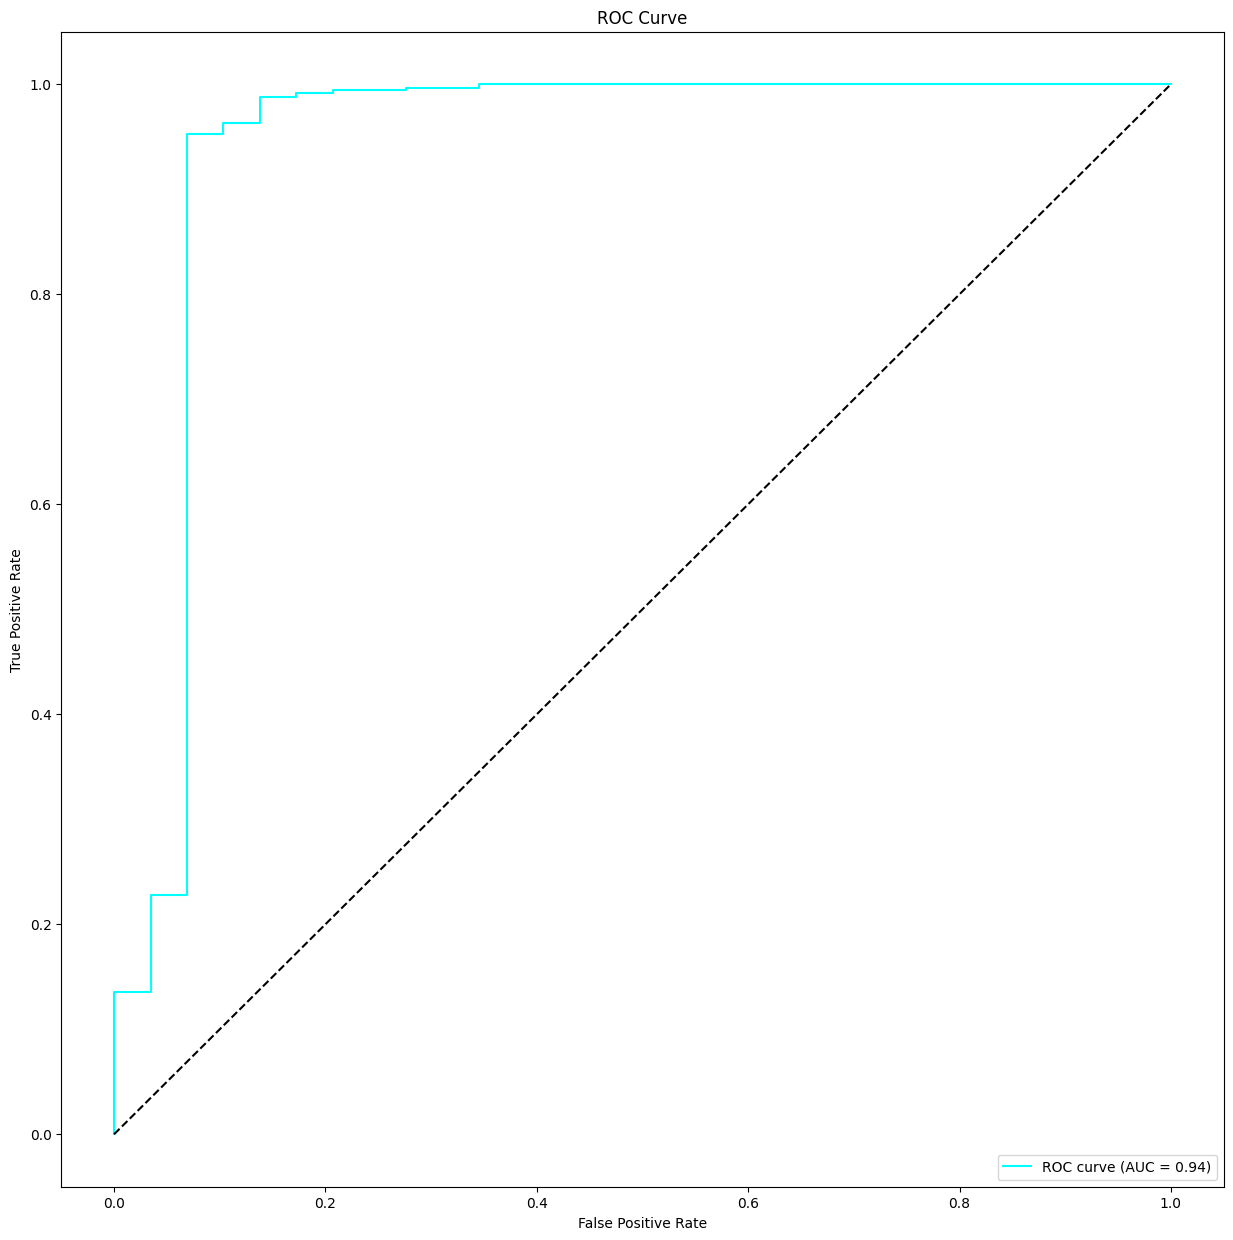

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.99      0.99      0.99       592

    accuracy                           0.98       621
   macro avg       0.88      0.91      0.89       621
weighted avg       0.98      0.98      0.98       621

##################################################  Saliency Maps  ##################################################

Class 0:


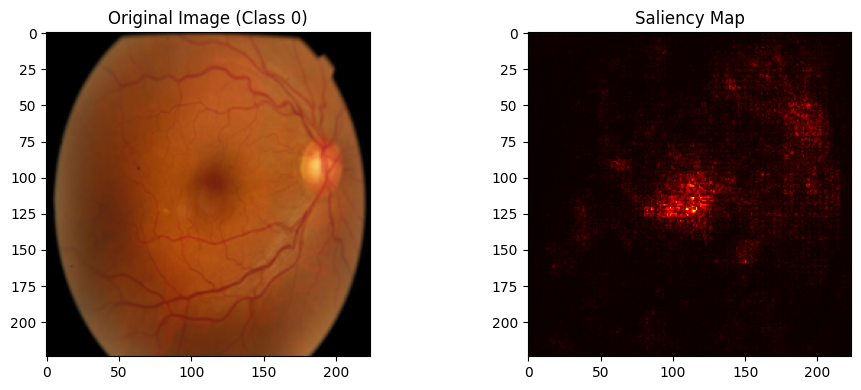

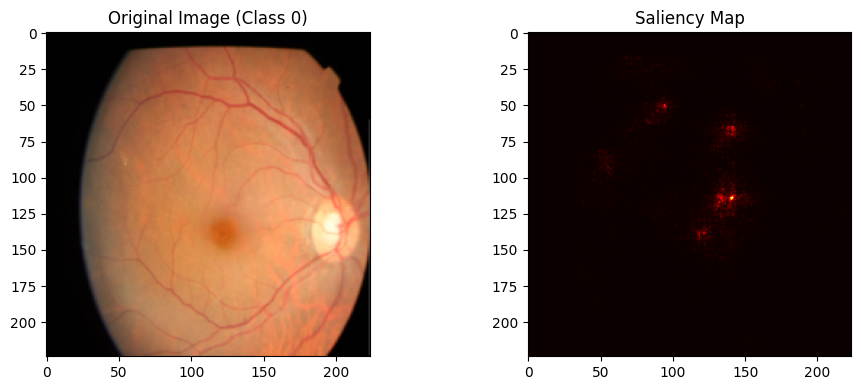

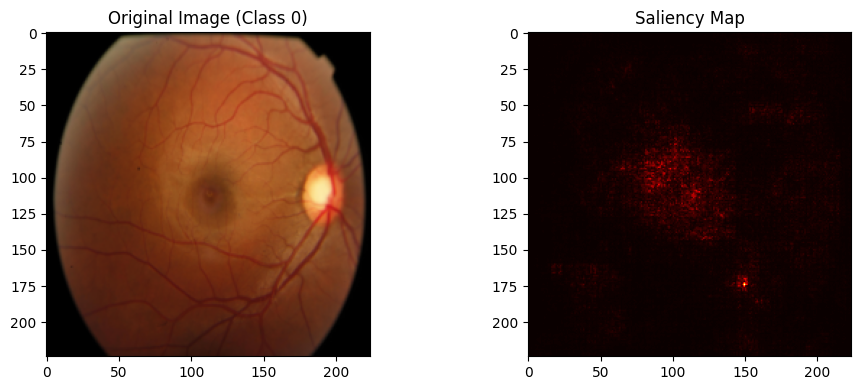

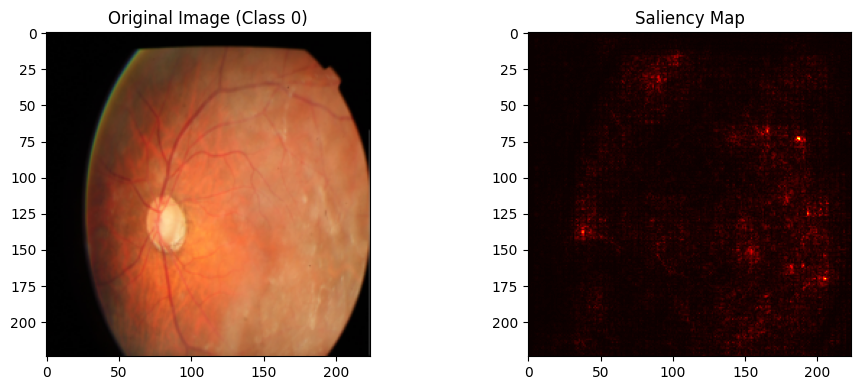

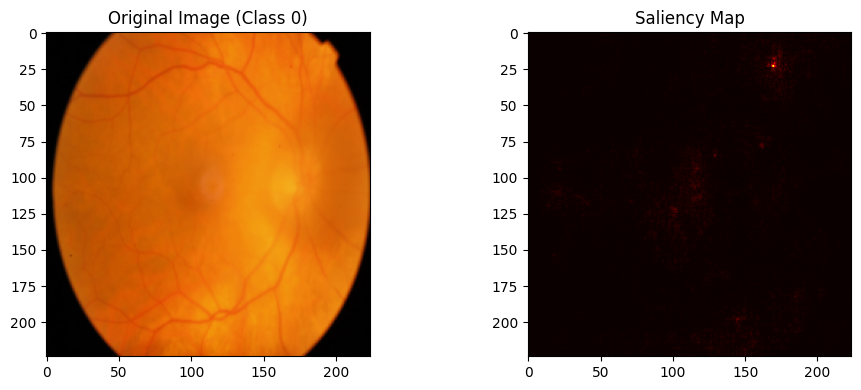

Class 1:


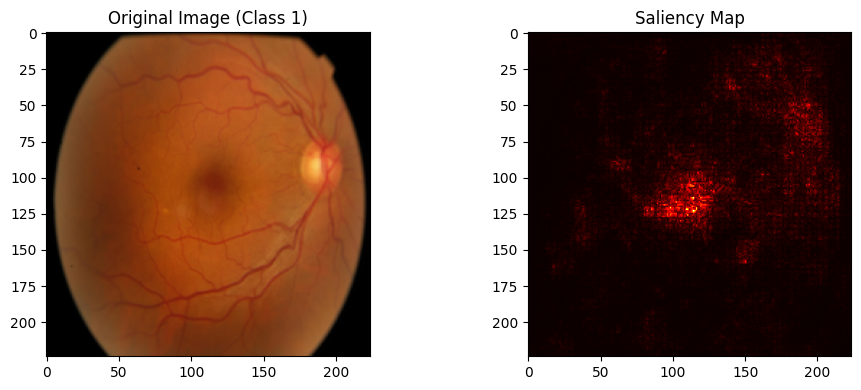

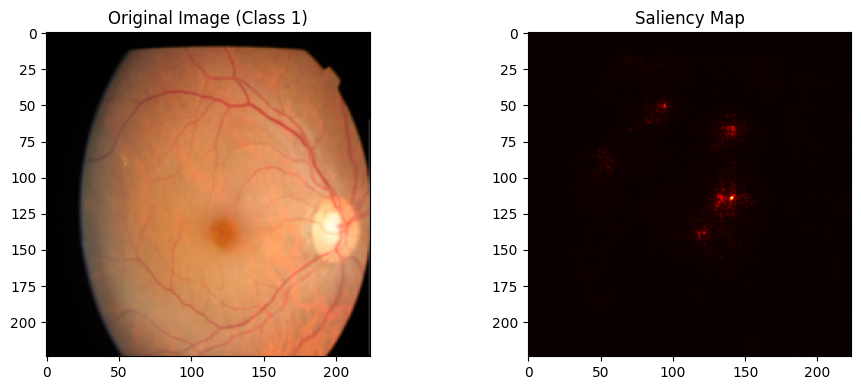

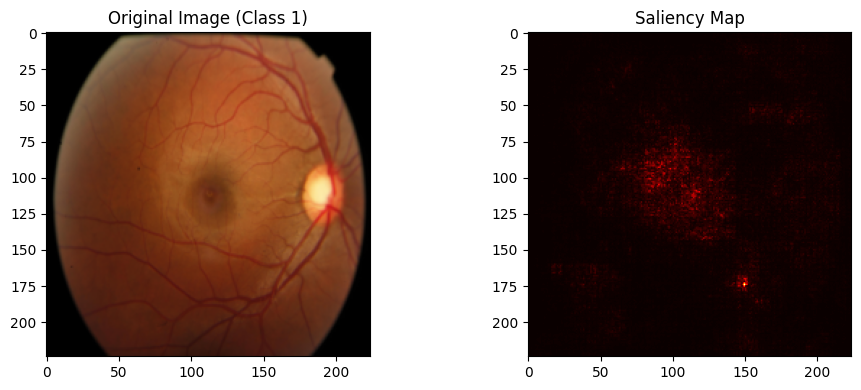

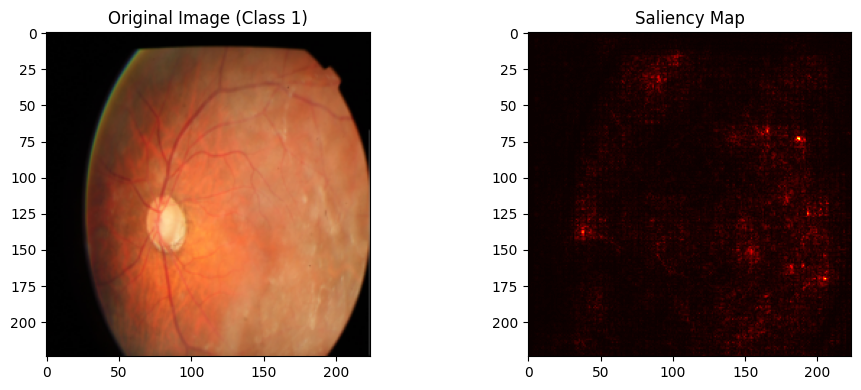

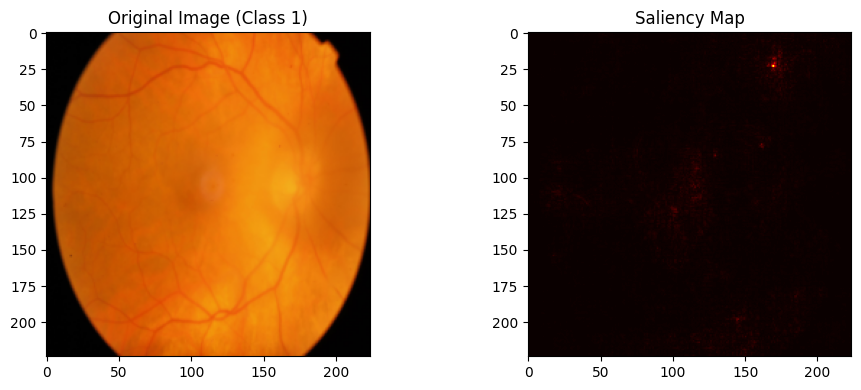

In [28]:
test(model, inadequate_dataloader, saliency=True, device=device)